In [17]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import joblib
import optuna

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import calibration_curve

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, roc_auc_score, log_loss, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

In [18]:
from sklearn import set_config
set_config(transform_output = 'pandas') # Retorna sempre um dataframe após transformação

In [19]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_train['data'] = pd.to_datetime(df_train['data'], format='%Y-%m-%d')
df_test['data'] = pd.to_datetime(df_test['data'], format='%Y-%m-%d')

In [20]:
df_odds = pd.read_csv('data/historico_odds.csv', encoding='latin-1', sep=';')

In [21]:
for col in ['PH', 'PD', 'PA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA']:
    df_odds[col] = df_odds[col].str.replace(',','.').astype(float)

df_odds['Date'] = pd.to_datetime(df_odds['Date'], format='%d/%m/%Y')

In [22]:
df_train = pd.merge(df_train,
                   df_odds[['Season','Home','Away', 'AvgH', 'AvgD', 'AvgA']],
                   how='left',
                   left_on=['ano_campeonato', 'time_man','time_vis'],
                   right_on=['Season','Home','Away']).drop(columns=['Season','Home','Away'])

df_test = pd.merge(df_test,
                   df_odds[['Season','Home','Away', 'AvgH', 'AvgD', 'AvgA']],
                   how='left',
                   left_on=['ano_campeonato', 'time_man','time_vis'],
                   right_on=['Season','Home','Away']).drop(columns=['Season','Home','Away'])

### Seleção de Features e Pré-processamento dos dados

Tanto o pre-processamento quanto a seleção de feature será feito sobre o conjunto de treinamento.

In [23]:
dropar = ['data',  'estadio', 'arbitro', 'time_man', 'tecnico_man', 'time_vis','tecnico_vis', 
          'vitoria_man', 'vitoria','ano_campeonato','rodada', 'AvgH', 'AvgD', 'AvgA']

# df_train.drop(columns=dropar, inplace=True)
# df_test.drop(columns=dropar, inplace=True)

X_train = df_train.drop(dropar ,axis=1)
y_train = df_train['vitoria']

X_test = df_test.drop(dropar ,axis=1)
y_test = df_test['vitoria']

In [24]:
cat_ord = ['tecnico_man_enc', 'tecnico_vis_enc', 'time_man_enc', 'time_vis_enc'] # Categoricas Ordinais (Resultado do Encoding)
num_features = [col for col in X_train.columns.to_list() if col not in cat_ord]

In [25]:
def cria_pipeline(num_varlist, cat_ord_varlist):
    
    num_pipeline = None
    cat_ord_pipeline = None

    if len(num_varlist) > 0:
        num_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', MinMaxScaler())
        ])
    if len(cat_ord_varlist) > 0:
        cat_ord_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')), # Para variaveis de encoding, imputa mising com a media
            ('scaler', MinMaxScaler())
        ])

    if num_pipeline is not None or cat_ord_pipeline is not None:
        transformers = []
        if num_pipeline is not None:
            transformers.append(('num', num_pipeline, num_varlist))
        if cat_ord_pipeline is not None:
            transformers.append(('cat_ord', cat_ord_pipeline, cat_ord_varlist))

        preprocessor = ColumnTransformer(transformers=transformers)

        return preprocessor
    else:
        return None

In [26]:
preprocessor_1 = cria_pipeline(num_features, cat_ord)
preprocessor_1.fit(X_train)
# joblib.dump(preprocessor, '../artifacts/preprocessor.pkl')
X_sel_train = preprocessor_1.transform(X_train)
X_sel_train.columns = X_train.columns

X_sel_test = preprocessor_1.transform(X_test)
X_sel_test.columns = X_test.columns

In [27]:
def remove_multicolinearidade(df_X, y, nome_var_resp, limiar=0.8):
    # Calcula a matriz de correlação entre as variáveis independentes
    df = df_X.copy()
    df[nome_var_resp] = y

    matriz_correlacao = df.drop(columns=[nome_var_resp]).corr()

    # Encontrar pares de variáveis altamente correlacionadas
    pares_correlacionados = []
    for i in range(len(matriz_correlacao.columns)):
        for j in range(i):
            if abs(matriz_correlacao.iloc[i, j]) > limiar:
                pares_correlacionados.append((matriz_correlacao.columns[i], matriz_correlacao.columns[j]))

    # Manter apenas a variável com maior correlação com a variável resposta para cada par
    dropar = []
    for var1, var2 in pares_correlacionados:
        corr_com_var_resp1 = df[var1].corr(df[nome_var_resp])
        corr_com_var_resp2 = df[var2].corr(df[nome_var_resp])

        if abs(corr_com_var_resp1) > abs(corr_com_var_resp2):
            dropar.append(var2)
        else:
            dropar.append(var1)

    # Remove as variáveis multicolineares do DataFrame
    df_filtrado = df.drop(columns=dropar)

    return df_filtrado.drop(columns=[nome_var_resp])

In [28]:
df_filter = remove_multicolinearidade(X_sel_train, y_train,'vitoria')

#### Estatística Univariada - ANOVA

In [29]:
f_values, p_values = f_classif(df_filter, y_train)
df_anova = pd.DataFrame({'VAR': df_filter.columns,
                         'F-Score': f_values,
                         'P-Valor': p_values})

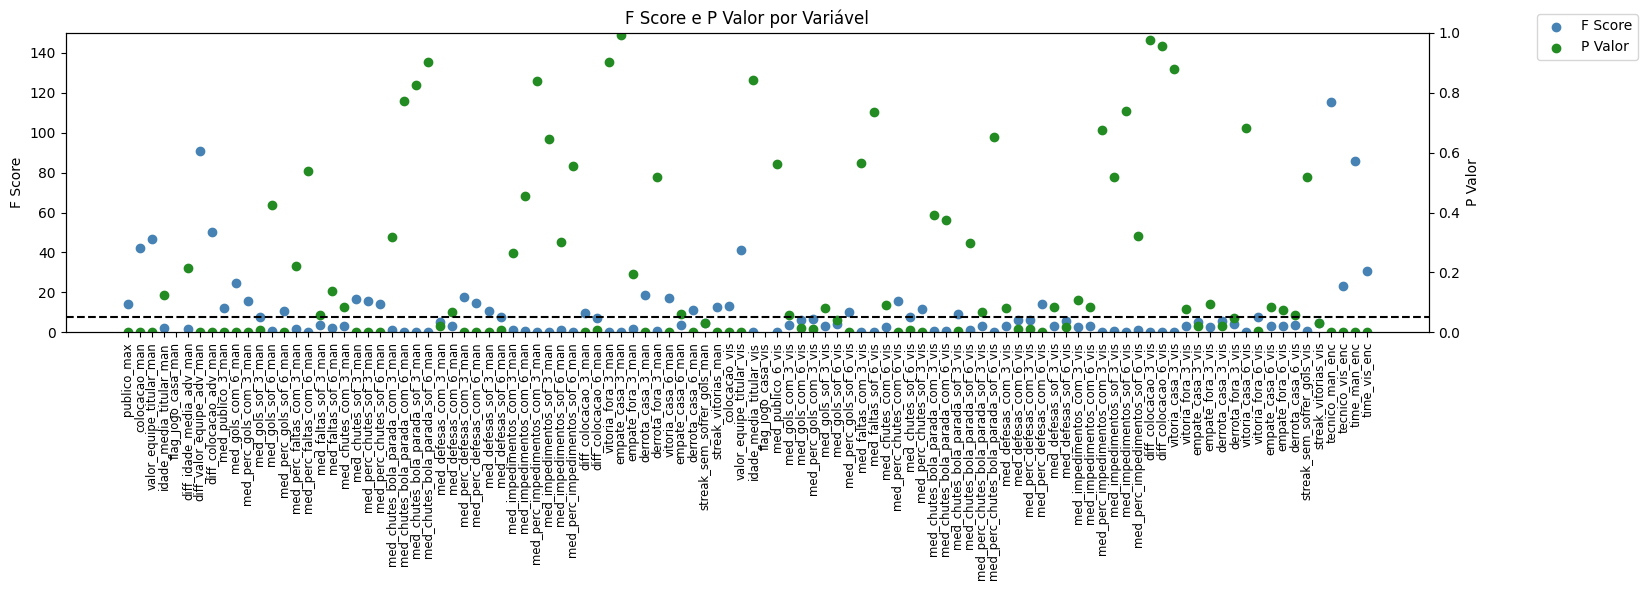

---- Variáveis em Ordem Descrescente de Força ----
tecnico_man_enc
diff_valor_equipe_adv_man
time_man_enc
diff_colocacao_adv_man
valor_equipe_titular_man
colocacao_man
valor_equipe_titular_vis
time_vis_enc
med_gols_com_6_man
tecnico_vis_enc
derrota_casa_3_man
med_perc_defesas_com_3_man
vitoria_casa_6_man
med_chutes_sof_3_man
med_perc_gols_com_3_man
med_perc_chutes_com_6_vis
med_perc_chutes_sof_3_man
med_perc_defesas_com_6_man
med_perc_defesas_com_6_vis
med_perc_chutes_sof_6_man
publico_max
colocacao_vis
streak_vitorias_man
med_publico_3_man
med_perc_chutes_sof_3_vis
derrota_casa_6_man
med_defesas_sof_3_man
med_perc_gols_sof_6_man
med_perc_gols_sof_6_vis
diff_colocacao_3_man
med_chutes_bola_parada_sof_3_vis
vitoria_fora_6_vis
med_defesas_sof_6_man
med_chutes_sof_6_vis
med_gols_sof_3_man
diff_colocacao_6_man
med_perc_gols_com_3_vis
med_perc_defesas_com_3_vis
med_defesas_com_6_vis
med_gols_com_6_vis
med_defesas_sof_6_vis
derrota_casa_3_vis
empate_casa_3_vis
med_defesas_com_3_man
streak_se

In [30]:
# Criar subplots com duplo eixo y
fig, axes1 = plt.subplots(figsize=(15, 6))

# Gráfico superior: Scatter plot F Score por variável
scatter1 = axes1.scatter(df_anova['VAR'], df_anova['F-Score'], color='steelblue', marker='o', label='F Score')
axes1.set_title('F Score e P Valor por Variável')
axes1.set_ylabel('F Score')
axes1.set_ylim(0,150)
axes1.tick_params(axis='x', rotation=90, labelsize='small')

# Criar segundo eixo y para o gráfico superior
axes2 = axes1.twinx()
scatter2 = axes2.scatter(df_anova['VAR'], df_anova['P-Valor'], color='forestgreen', marker='o', label='P Valor')
axes2.set_ylabel('P Valor')
axes2.set_ylim(0,1)

# Adicionar linha horizontal tracejada em P valor 0.05 no gráfico inferior
axes2.axhline(y=0.05, color='black', linestyle='--', label='P Valor = 0.05')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Adicionar legenda combinada
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
fig.legend(scatters, labels, loc='upper right', bbox_to_anchor=(1.10, 0.98))

plt.show()

vars_anova = df_anova[df_anova['P-Valor'] < 0.05].sort_values(by='F-Score', ascending=False)['VAR'].tolist()
df_anova['SEL'] = 0
print('---- Variáveis em Ordem Descrescente de Força ----')
for v in vars_anova:
    df_anova.loc[df_anova['VAR']==v,'SEL'] = 1
    print(v)

#### Model Based
- Selecao Baseada em Modelo - Random Forest

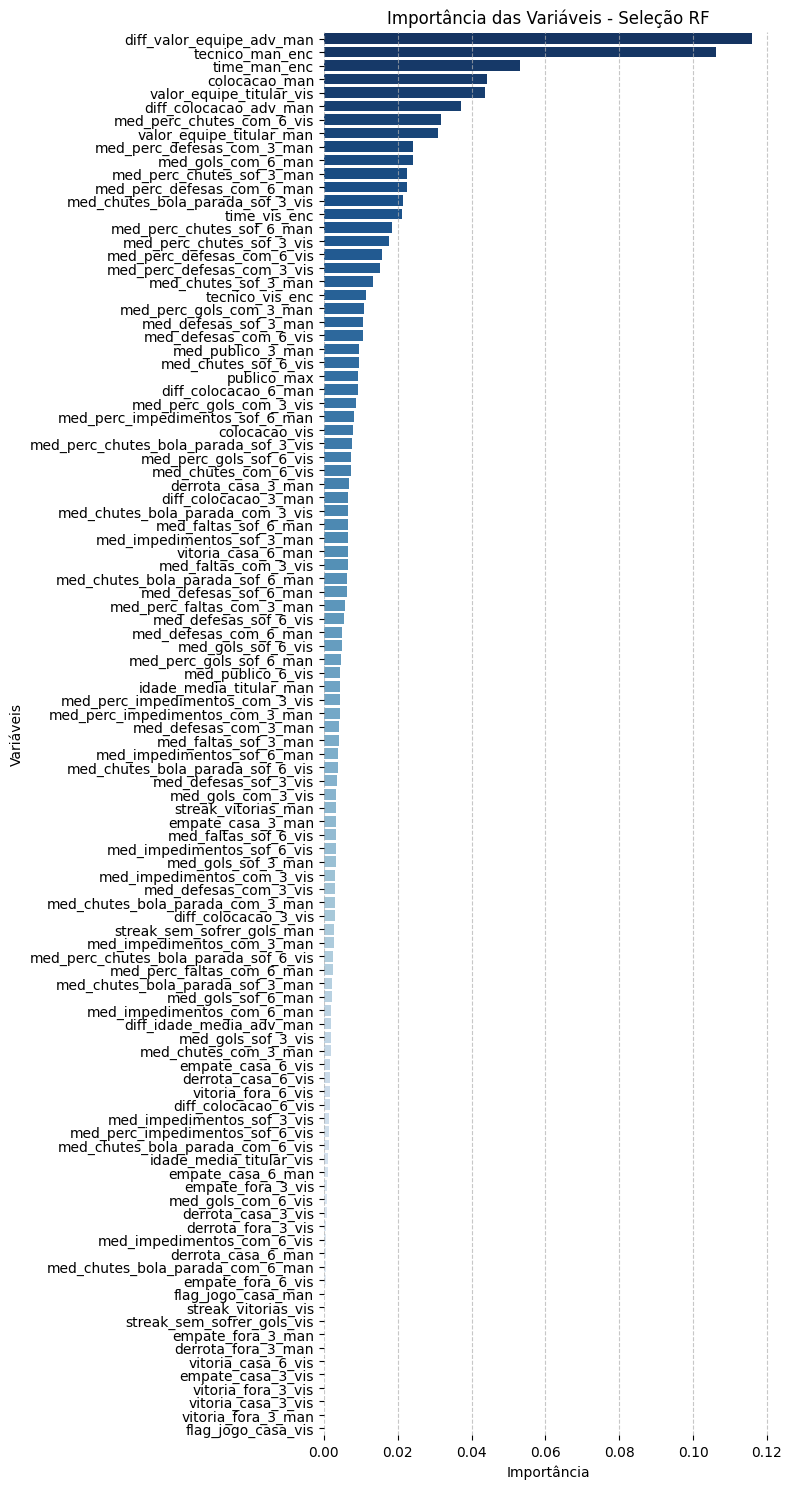

In [34]:
# Crie um modelo de RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# Treine o modelo
rf_model.fit(df_filter, y_train)

# Obtenha a importância das características
feature_importances = pd.DataFrame({'VAR': df_filter.columns, 'IMP': rf_model.feature_importances_})

# Crie um gráfico de barras para visualizar a importância das características
plt.figure(figsize=(8, 15))
sns.barplot(data=feature_importances.sort_values(by='IMP', ascending=False), x='IMP', y='VAR', palette='Blues_r')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis - Seleção RF')
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observa-se claramente que as importâncias estão concentradas nas primeiras 12 variáveis (med_perc_defesas_com_3 pra cima). Assim, podemos adotar um corte na importancia de 0.03

In [35]:
feature_importances['RF_SEL'] = 0
feature_importances.loc[feature_importances['IMP']>0.02, 'RF_SEL'] = 1

In [37]:
feature_importances[feature_importances['RF_SEL']==1].sort_values(by='IMP',ascending=False)

,VAR,IMP,RF_SEL
6,diff_valor_equipe_adv_man,0.115845,1
100,tecnico_man_enc,0.106323,1
102,time_man_enc,0.053055,1
1,colocacao_man,0.044106,1
51,valor_equipe_titular_vis,0.043614,1
7,diff_colocacao_adv_man,0.037080,1
64,med_perc_chutes_com_6_vis,0.031604,1
2,valor_equipe_titular_man,0.030936,1
28,med_perc_defesas_com_3_man,0.024224,1
9,med_gols_com_6_man,0.024082,1


Agora, vamos observar como se comporta a precisão de um modelo RF baseline à medida que vamos retirando as variáveis por ordem crescente de importância.
Para este teste, vamos utilizar todas as variáveis.

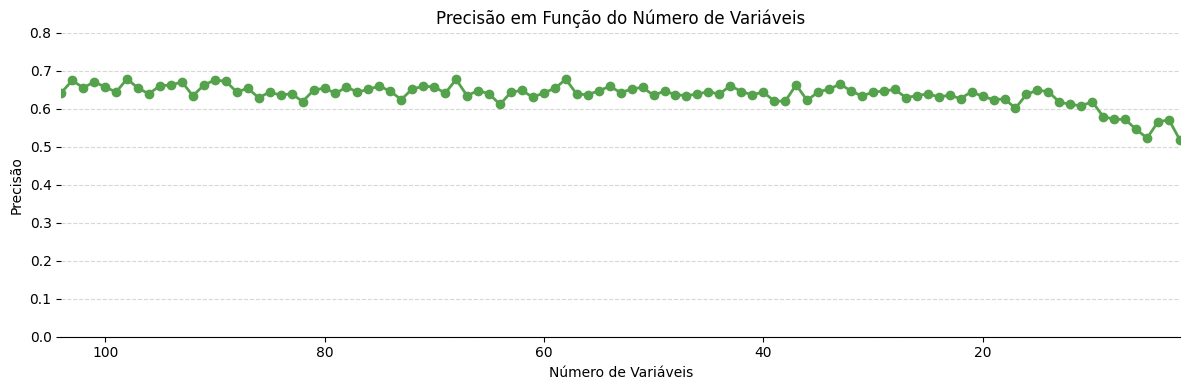

In [44]:
feat_desc = feature_importances.sort_values(by='IMP',ascending=False)['VAR'].to_list()
num_features_list = []
precision_list = []

for i in range(len(feat_desc),1,-1):
    
    selected_features_subset = feat_desc[:i]
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)    
    rf_model.fit(df_filter[selected_features_subset], y_train)    
    y_pred = rf_model.predict(X_sel_test[selected_features_subset])
    
    precision = precision_score(y_test, y_pred)
    num_features_list.append(i)
    precision_list.append(precision)

plt.figure(figsize=(12, 4))
plt.plot(num_features_list, precision_list, marker='o', linestyle='-', linewidth=2, color='#54a24b')
plt.xlabel('Número de Variáveis')
plt.ylabel('Precisão')
plt.title('Precisão em Função do Número de Variáveis')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
# plt.grid(True)
sns.despine(left=True)
plt.xlim(np.max(num_features_list), np.min(num_features_list))
plt.ylim(0, 0.8)

plt.tight_layout()
plt.show()

Nota-se que a partir de 15 variáveis a precisão do Modelo Baseline começa a perder força.

In [50]:
df_compara_sel = pd.merge(df_anova, feature_importances, on='VAR', how='inner')
df_compara_sel.sort_values(by='IMP',ascending=False, inplace=True)
df_compara_sel

,VAR,F-Score,P-Valor,SEL,IMP,RF_SEL
6,diff_valor_equipe_adv_man,91.048082,7.296364e-21,1,0.115845,1
100,tecnico_man_enc,115.260309,9.283641e-26,1,0.106323,1
102,time_man_enc,85.565436,9.678905e-20,1,0.053055,1
1,colocacao_man,42.239374,1.172706e-10,1,0.044106,1
51,valor_equipe_titular_vis,41.195799,1.964941e-10,1,0.043614,1
...,...,...,...,...,...,...
89,empate_casa_3_vis,5.371796,2.062914e-02,1,0.000000,0
88,vitoria_fora_3_vis,3.122868,7.744995e-02,0,0.000000,0
87,vitoria_casa_3_vis,0.022963,8.795774e-01,0,0.000000,0
40,vitoria_fora_3_man,0.015063,9.023384e-01,0,0.000000,0


In [51]:
vars_sel = df_compara_sel[(df_compara_sel['SEL']==1) & (df_compara_sel['RF_SEL']==1)]['VAR'].to_list()

As variáveis selecionadas com intersecção do método univariado por ANOVA e baseado em modelo por RandomForest são as mesmas 12 que foram selecionadas por RandomForest

In [52]:
vars_sel

['diff_valor_equipe_adv_man',
 'tecnico_man_enc',
 'time_man_enc',
 'colocacao_man',
 'valor_equipe_titular_vis',
 'diff_colocacao_adv_man',
 'med_perc_chutes_com_6_vis',
 'valor_equipe_titular_man',
 'med_perc_defesas_com_3_man',
 'med_gols_com_6_man',
 'med_perc_chutes_sof_3_man',
 'med_perc_defesas_com_6_man',
 'med_chutes_bola_parada_sof_3_vis',
 'time_vis_enc']

Uma vez que temos as variáveis finais, podemos criar um preprocessor final para utilizar de pipeline para dados futuros.

OBS: As variáveis time_enc e time_adversario_enc foram retiradas de forma a evitar overfitting ou ocasionar um viés em relação ao time vs. time adversário. Assim, manteremos apenas o tecnico como variável encoded.

In [53]:
vars_final = [
    'diff_valor_equipe_adv_man',
    'tecnico_man_enc',
    'time_man_enc',
    'colocacao_man',
    'valor_equipe_titular_vis',
    'diff_colocacao_adv_man',
    'med_perc_chutes_com_6_vis',
    'valor_equipe_titular_man',
    'med_perc_defesas_com_3_man',
    'med_gols_com_6_man',
    # 'med_perc_chutes_sof_3_man',
    # 'med_perc_defesas_com_6_man',
    'med_chutes_bola_parada_sof_3_vis',
    'time_vis_enc'
 ]

num_finais = [
    'diff_valor_equipe_adv_man',    
    'colocacao_man',
    'valor_equipe_titular_vis',
    'diff_colocacao_adv_man',
    'med_perc_chutes_com_6_vis',
    'valor_equipe_titular_man',
    'med_perc_defesas_com_3_man',
    'med_gols_com_6_man',    
    'med_chutes_bola_parada_sof_3_vis'
 ]

cat_ord_finais = [
    'tecnico_man_enc', 
    'time_man_enc', 
    'time_vis_enc'
]

# cat_ord_finais = []


preprocessor_final = cria_pipeline(num_finais, cat_ord_finais)
preprocessor_final.fit(X_train[vars_final])
joblib.dump(preprocessor_final, '../artifacts/preprocessor.pkl')

X_train_f = preprocessor_final.transform(X_train[vars_final])
X_train_f.columns = X_train[vars_final].columns

X_test_f = preprocessor_final.transform(X_test[vars_final])
X_test_f.columns = X_test[vars_final].columns

### Treinamento do Modelo

Para avaliar a performance do Modelo, precisamos treiná-lo utilizando uma métrica de maximização. Podemos escolher a precisão, que mede a proporção de todas as previsões corretas que o modelo fez. Além disso, podemos utilizar uma abordagem de retorno para apostas através da métrica ROI (Return Over Investment)

Sendo assim, vamos combinar a precisão e o ROI na nossa métrica de maximização, adotando pesos para ambos.
Em resumo:

-   O ROI mede a lucratividade financeira, indicando diretamente a capacidade do modelo de gerar retornos sobre o investimento.
-   A precisão é ideal para evitar falsos positivos. Com isso, evitariamos perdas financeiras ao apostar na vitoria de um determinado jogo.

Para cada jogo vamos considerar que será apostado $10 e que para cada ganho, tenha um lucro de 10% sobre o valor apostado

In [54]:
def roi_score(y_true, y_pred_proba, stake_per_bet=10):
    '''
    Calcula o retorno sobre o investimento (ROI)
    '''   

    y_pred = (y_pred_proba >= 0.5).astype(int) # Limiar de 0.5

    total_bets = len(y_true)
    total_wins = sum(y_true * y_pred)

    total_payouts = total_wins * stake_per_bet * 1.1  # Considerando 10% de lucro em vitorias
    total_staked = total_bets * stake_per_bet # Total apostado nao considerando lucros
    net_profit = total_payouts - total_staked
    
    return (net_profit / total_staked)

In [55]:
def cost_sensitive_precision(y_true, y_pred, tp_weight=1, fp_weight=5):
    '''
    Calcula a Precisao com pesos aplicados no TP e FP de 
    forma a penalizar falsos positivos.

    Este método é util quando temos classes desbalanceada. No nosso caso, a taxa de vitoria é 30%
    '''    

    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]  
    fp = cm[0, 1] 

    weighted_tp = -tp_weight*tp
    weighted_fp = -fp_weight*fp    

    cost_sensitive_precision = weighted_tp / (weighted_tp + weighted_fp)

    if np.isnan(cost_sensitive_precision):
        return 0
    else:
        return cost_sensitive_precision

In [56]:
def evaluate_calibration(y_true, y_prob, n_bins=5):
    """
    Calculates calibration metrics.

    Args:
        y_true (array-like): True binary outcomes (0 or 1).
        y_prob (array-like): Predicted probabilities of positive class.
        n_bins (int, optional): Number of bins for calibration curve. Defaults to 5.

        Expected Calibration Error (ECE)
    """

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

        # Calculate ECE
    ece = np.abs(prob_true - prob_pred).mean()

    return ece

In [57]:
# Juntando a variável resposta nos dados de treino 
df_train_f = pd.concat([X_train_f, y_train], axis=1)

In [70]:
len(df_train_f)

1226

In [79]:
tscv = TimeSeriesSplit(n_splits=3, max_train_size=600, test_size=250)
# tscv = TimeSeriesSplit(n_splits=4)

# metrics_folds = []    
for i, (train_index, test_index) in enumerate(tscv.split(df_train_f)):

    tam_treino = len(train_index)
    tam_teste = len(test_index)
    total = tam_treino + tam_teste
    print(f'TREINO: {tam_treino}, TESTE: {tam_teste}, SOMA: {total}')
    print(f'TREINO: {train_index}, TESTE: {test_index}')

TREINO: 476, TESTE: 250, SOMA: 726
TREINO: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235

In [58]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [80]:
def objective(trial, model_name):
    model = None

    model_seed = 42

    if model_name == 'RandomForest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            max_depth=trial.suggest_int('max_depth', 1, 5),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 300),            
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 100),
            bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
            random_state=model_seed
        )
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(
            C=trial.suggest_float('C', 1e-3, 1e3, log=True),
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            solver=trial.suggest_categorical('solver', ['liblinear', 'saga']),
            max_iter=trial.suggest_int('max_iter', 100, 1000),
            tol=trial.suggest_float('tol', 1e-4, 1e-2, log=True),                        
            random_state=model_seed
        )
    elif model_name == 'LGBM':
        model = LGBMClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            max_depth=trial.suggest_int('max_depth', 1, 8),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
            num_leaves=trial.suggest_int('num_leaves', 10, 150),
            min_data_in_leaf=trial.suggest_int('min_data_in_leaf', 10, 200),            
            bagging_fraction=trial.suggest_float('bagging_fraction', 0.01, 1.0),
            reg_alpha=trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
            reg_lambda=trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
            verbose=-1,
            random_state=model_seed
        )
    elif model_name == 'NaiveBayes':
        model = GaussianNB(
            var_smoothing=trial.suggest_float('var_smoothing', 1e-9, 1e-4, log=True)
        )
    elif model_name == 'AdaBoostClassifier':
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
            random_state=model_seed
        )
    elif model_name == 'KNN':
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 20),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
            p=trial.suggest_int('p', 1, 2)
        )
    elif model_name == 'SVC':
        model = SVC(
            C=trial.suggest_float('C', 1e-3, 1e3, log=True),
            # kernel=trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            kernel=trial.suggest_categorical('kernel', ['linear']),
            gamma=trial.suggest_float('gamma', 1e-3, 1e3, log=True),
            shrinking=trial.suggest_categorical('shrinking', [True, False]), 
            probability=trial.suggest_categorical('probability', [True]),            
            random_state=model_seed
        )
    elif model_name == 'DecisionTree':
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 6),
            min_samples_split=trial.suggest_int('min_samples_split', 5, 100),
            max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 2, 30),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            random_state=model_seed
        )
        
    tscv = TimeSeriesSplit(n_splits=3, max_train_size=600, test_size=250)
    metrics_folds = []    
    for i, (train_index, test_index) in enumerate(tscv.split(df_train_f)):

        train = df_train_f.iloc[train_index]
        X_train = train.drop(['vitoria'],axis=1)
        y_train = train['vitoria']

        valid = df_train_f.iloc[test_index]
        X_valid = valid.drop(['vitoria'],axis=1)
        y_valid = valid['vitoria']

        model.fit(X_train, y_train)        
        y_pred_proba = model.predict_proba(X_valid)[:, 1]        
        
        result = log_loss(y_valid, y_pred_proba)
        metrics_folds.append(result)
               
    return np.mean(metrics_folds)  

    # train = df_train_f.iloc[:861] # 70%
    # X_train = train.drop(['vitoria'],axis=1)
    # y_train = train['vitoria']
    # valid = df_train_f.iloc[861:] # 30%
    # X_valid = valid.drop(['vitoria'],axis=1)
    # y_valid = valid['vitoria']

    # model.fit(X_train, y_train)    
    # y_pred_proba = model.predict_proba(X_valid)[:, 1]       
    
    # result = log_loss(y_valid, y_pred_proba)    

    # return result

In [82]:
models = ['RandomForest', 'LogisticRegression', 'LGBM', 'NaiveBayes', 'AdaBoostClassifier', 'KNN', 'SVC', 'DecisionTree']

comparison_df = pd.DataFrame(columns=['model', 'best_params', 'best_value'])

for model_name in models:

    print(f'------ {model_name} ------')

    sampler = optuna.samplers.TPESampler(seed = 42)
    study = optuna.create_study(direction='minimize', sampler=sampler)

    study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

    best_params = study.best_params
    print(f'Melhores parametros: {best_params}')
    best_value = round(study.best_value,4)
    print(f'Melhor valor  {best_value}')

    df_aux = pd.DataFrame({
        'model': [model_name],
        'best_params': [best_params],
        'best_value': [best_value]
    })

    comparison_df = pd.concat([comparison_df, df_aux],ignore_index=True)

    del df_aux

------ RandomForest ------
Melhores parametros: {'n_estimators': 186, 'max_depth': 5, 'criterion': 'gini', 'min_samples_split': 106, 'min_samples_leaf': 16, 'bootstrap': True}
Melhor valor  0.6449
------ LogisticRegression ------
Melhores parametros: {'C': 0.8698882149824841, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 386, 'tol': 0.00019417463169189365}
Melhor valor  0.6314
------ LGBM ------
Melhores parametros: {'n_estimators': 167, 'max_depth': 4, 'learning_rate': 0.037272161533600925, 'num_leaves': 116, 'min_data_in_leaf': 199, 'bagging_fraction': 0.6231157670978775, 'reg_alpha': 0.0010145680728880638, 'reg_lambda': 0.31330170590475837}
Melhor valor  0.6425
------ NaiveBayes ------
Melhores parametros: {'var_smoothing': 9.931901475257164e-05}
Melhor valor  0.9775
------ AdaBoostClassifier ------
Melhores parametros: {'n_estimators': 222, 'learning_rate': 0.0031261029103110596}
Melhor valor  0.658
------ KNN ------
Melhores parametros: {'n_neighbors': 20, 'weights': 'distan

In [83]:
comparison_df.sort_values(by='best_value',ascending=True)

,model,best_params,best_value
6,SVC,"{'C': 0.11414081613170533, 'kernel': 'linear',...",0.6310
1,LogisticRegression,"{'C': 0.8698882149824841, 'penalty': 'l2', 'so...",0.6314
2,LGBM,"{'n_estimators': 167, 'max_depth': 4, 'learnin...",0.6425
0,RandomForest,"{'n_estimators': 186, 'max_depth': 5, 'criteri...",0.6449
5,KNN,"{'n_neighbors': 20, 'weights': 'distance', 'p'...",0.6545
4,AdaBoostClassifier,"{'n_estimators': 222, 'learning_rate': 0.00312...",0.6580
7,DecisionTree,"{'max_depth': 2, 'min_samples_split': 5, 'max_...",0.6631
3,NaiveBayes,{'var_smoothing': 9.931901475257164e-05},0.9775


In [134]:
# Com ECE
comparison_df.sort_values(by='best_value',ascending=True)

,model,best_params,best_value
1,LogisticRegression,"{'C': 0.840890658104122, 'penalty': 'l2', 'sol...",0.6583
6,SVC,"{'C': 957.6921590383761, 'kernel': 'linear', '...",0.6603
2,LGBM,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",0.6627
0,RandomForest,"{'n_estimators': 275, 'max_depth': 3, 'criteri...",0.6645
5,KNN,"{'n_neighbors': 19, 'weights': 'uniform', 'p': 2}",0.6751
4,AdaBoostClassifier,"{'n_estimators': 135, 'learning_rate': 0.01789...",0.6772
7,DecisionTree,"{'max_depth': 1, 'min_samples_split': 10, 'max...",0.6849
3,NaiveBayes,{'var_smoothing': 9.964550094689261e-05},0.9398


O modelo que apresentou desempenho superior após a otimização de seus hiperparâmetros foi a Regressão Logistica. Agora, procederemos à sua instanciação e avaliação no conjunto de teste.

In [88]:
# Com LOG LOSS
# model_f = LogisticRegression(C=979.5745813167302,
#               penalty='l2',
#               solver='liblinear',
#               max_iter=903,
#               tol= 0.0058089583756064985,
#               random_state=42)

model_f = SVC(C=0.11414081613170533,
              kernel='linear',
              gamma=0.01827618492117167,
              shrinking=False,
              probability=True,
              random_state=42)

# Com AUC SCORE
# model_f = LogisticRegression(C=145.76956201941084,
#               penalty='l1',
#               solver='liblinear',
#               max_iter=844,
#               tol= 0.002377384436383541,
#               random_state=42)


model_f.fit(X_train_f, y_train)
pred_train = model_f.predict(X_train_f)
pred_proba_train = model_f.predict_proba(X_train_f)[:,1]
pred_f = model_f.predict(X_test_f)
pred_proba_test = model_f.predict_proba(X_test_f)[:,1]

print('--- TREINO ---')
print(f'ROI: {roi_score(y_train, pred_train)}')
print(f'Precisao Penalizada: {cost_sensitive_precision(y_train, pred_train)}')
print(f'Precisao: {precision_score(y_train, pred_train)}')
print(f'ROC: {roc_auc_score(y_train, pred_proba_train)}')

print('--- TESTE ---')
print(f'ROI: {roi_score(y_test, pred_f)}')
print(f'Precisao Penalizada: {cost_sensitive_precision(y_test, pred_f)}')
print(f'Precisao: {precision_score(y_test, pred_f)}')
print(f'ROC: {roc_auc_score(y_test, pred_proba_test)}')

--- TREINO ---
ROI: -0.7353181076672104
Precisao Penalizada: 0.2565217391304348
Precisao: 0.6330472103004292
ROC: 0.703878432003432
--- TESTE ---
ROI: -0.7527619047619047
Precisao Penalizada: 0.25213675213675213
Precisao: 0.6276595744680851
ROC: 0.6532653061224489


In [ ]:
# --- TREINO ---
# ROI: -0.7451876019575856
# Precisao Penalizada: 0.23490488006617039
# Precisao: 0.605543710021322
# ROC: 0.6696080008580008
# --- TESTE ---
# ROI: -0.7276190476190476
# Precisao Penalizada: 0.26
# Precisao: 0.6372549019607843
# ROC: 0.6848542274052479

In [ ]:
# AUC
# --- TREINO ---
# ROI: -0.8853107344632768
# Precisao Penalizada: 0.22989807474518686
# Precisao: 0.5988200589970502
# --- TESTE ---
# ROI: -0.8853892215568863
# Precisao Penalizada: 0.29292929292929293
# Precisao: 0.6744186046511628

In [89]:
df_test_f = pd.concat([X_test_f, y_test], axis=1)
df_test_f['pred_vitoria'] = model_f.predict_proba(X_test_f)[:, 1] 

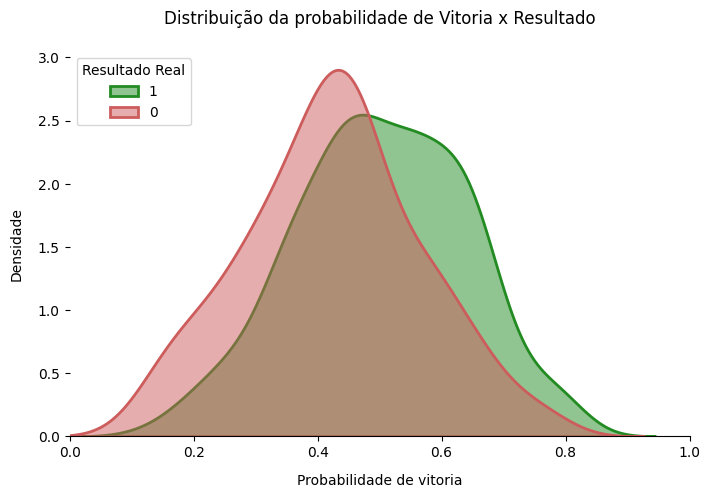

pred_vitoria                                                    \
               count      mean       std       min       25%       50%   
vitoria                                                                  
0              280.0  0.423788  0.142725  0.084559  0.327318  0.426363   
1              245.0  0.501429  0.137297  0.132308  0.407453  0.500000   

                             
              75%       max  
vitoria                      
0        0.510637  0.788301  
1        0.606535  0.807770

In [90]:
plt.figure(figsize=(8,5))

sns.kdeplot(df_test_f, 
            x='pred_vitoria', 
            hue='vitoria', 
            fill=True, 
            common_norm=False,
            alpha=0.5, 
            linewidth=2,
            palette=['indianred','forestgreen']
            )

plt.xlabel('Probabilidade de vitoria', labelpad=10)
plt.ylabel('Densidade', labelpad=10)
plt.title('Distribuição da probabilidade de Vitoria x Resultado', fontsize=12, pad=20)
plt.legend(title='Resultado Real', title_fontsize=10, labels=['1','0'], loc='upper left')

plt.xlim(0, 1)
sns.despine(left=True)
plt.show()

df_test_f.groupby('vitoria')[['pred_vitoria']].describe()

In [100]:
df_test_f['AvgH'] = df_test['AvgH']
df_test_f['AvgA'] = df_test['AvgA']

preds_prob_w = df_test_f['pred_vitoria'].values
preds_prob_l = (1 - df_test_f['pred_vitoria']).values
y_true = df_test_f['vitoria'].values
odds_homewin = df_test_f['AvgH'].values
odds_awaywin = df_test_f['AvgA'].values

In [92]:
def kelly_criterion_fraction(probability, odds, fraction=1.0):
    """
    Calculate the Kelly Criterion fraction for optimal bet sizing.

    Parameters:
    - odds: Decimal odds (e.g., 2.0 for even money, 3.0 for 2:1 odds, etc.).
    - probability: Probability of winning (should be between 0 and 1).
    - fraction: Fraction of the current bankroll to consider (default is 1.0).

    Returns:
    - The fraction of the current bankroll to bet according to the Kelly Criterion.
    """
    b = odds - 1  # Net odds received on the bet
    q = 1 - probability
    kelly = (b * probability - q) / b

    # Ensure the fraction is within the specified limits
    kelly_fraction = fraction*kelly

    return kelly_fraction

Lucro total (k = 1): -991.3291771233361
Lucro total (k = 0.5): -758.3809182627976
Lucro total (k = 0.25): -381.1820384826418
Lucro total (k = 0.125): -166.52074087279567


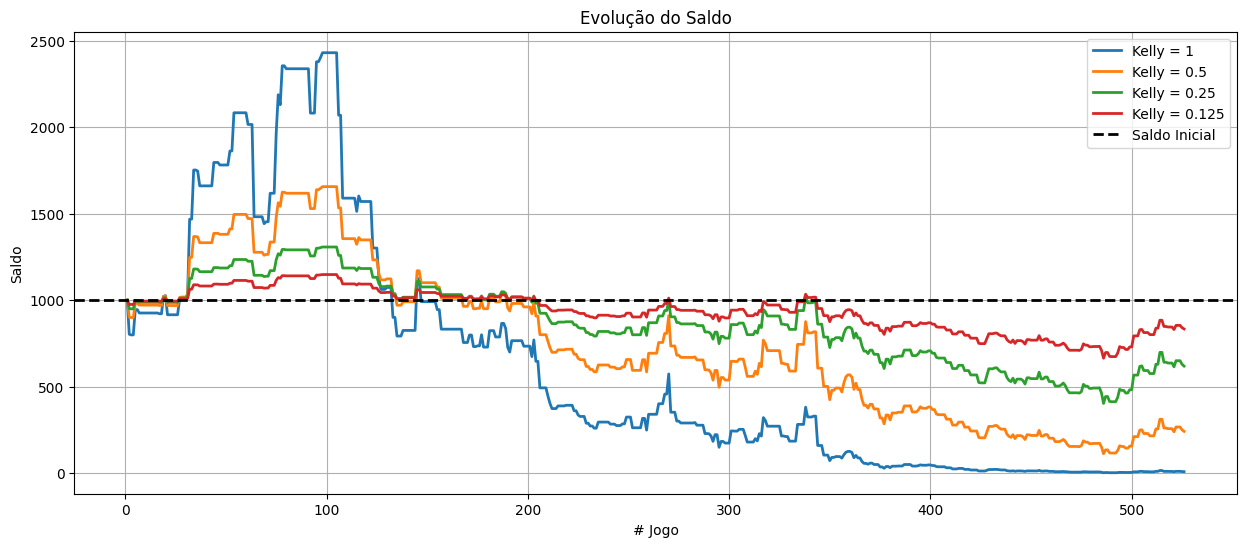

,total_apostado,%_jogos_apostados,%_apostas_ganhas,fracao_kelly,saldo_final,%_roi
0,10894.49,41.63,41.55,1.000,8.67,-99.13
1,8328.30,41.63,41.55,0.500,241.62,-75.84
2,5528.13,41.63,41.55,0.250,618.82,-38.12
3,3149.10,41.63,41.55,0.125,833.48,-16.65


In [104]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
# odds = 1.8
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000 
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros = [], [], []    
    for prob, odds, outcome in zip(preds_prob_w, odds_homewin, y_true):
        
        f_star = kelly_criterion_fraction(prob, odds, k)       
        stake = f_star*bankroll

        if stake < 0:
            stake = 0

        if outcome == 1:
            # winning = 1
            win_value = stake * (odds - 1)
            lucros.append(win_value)
            bankroll += win_value
        else:
            # winning = 0
            bankroll -= stake
            lucros.append(-stake)
        
        aposta_ganha = (1 if stake*outcome>0 else 0)
        
        stakes.append(stake)        
        apostas_ganhas.append(aposta_ganha)
        bankroll_history.append(bankroll)

    # print(stakes)
    print(f'Lucro total (k = {k}): {np.sum(lucros)}')
    valor_total_apostado = np.sum(stakes) 
    roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum([1 if s>0 else 0 for s in stakes])
    qtd_apostas_ganhas = np.sum(apostas_ganhas)

    df_k = pd.DataFrame({'total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi,2)]
    })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

# Customize plot
plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

In [98]:
df_test_f['AvgH'] = df_test['AvgH']
df_test_f['AvgA'] = df_test['AvgA']

preds_prob_w = df_test_f['pred_vitoria'].values
preds_prob_l = (1 - df_test_f['pred_vitoria']).values
y_true = df_test_f['vitoria'].values
odds_homewin = df_test_f['AvgH'].values
odds_awaywin = df_test_f['AvgA'].values

In [ ]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
# odds = 1.8
dfs_resumo = []

In [152]:
def betting_simulation(B0, Pmin, Lt, Ut, kelly_fractions = [1, 0.5, 0.25, 0.125], plot=True):
    """Simula uma estratégia de apostas em um conjunto de dados fornecido.

    Argumentos:    
    B0 (float): Saldo inicial.    
    Pmin (float): Probabilidade predita mínima para uma aposta.
    Lt (float): Diferença mínima entre probabilidades preditas e implícitas.
    Ut (float): Diferença máxima entre probabilidades preditas e implícitas.
    kelly_fractions (lista): Lista de parametros para fração Kelly.
    plot (bool): Escolhe se Plota ou nao um grafico da evolução do Saldo.
    """ 
    if plot:
        plt.figure(figsize=(15, 6))

    dfs_resumo = []
    for k in kelly_fractions:
        bankroll = B0 
        bankroll_history = [bankroll]
        stakes, apostas_ganhas, lucros = [], [], []

        for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):
            # Verifica se a diferença da probabilidade do modelo (vitoria) está dentro dos intervalos estabelecidos e 
            # se a probabilidade do modelo (vitoria) é maior que uma probabilidade minima para se apostar.
            if Lt < (prob_w - 1 / odds_w) < Ut and prob_w > Pmin: 
                f_star = kelly_criterion_fraction(prob_w, odds_w, k) # Calcula Kelly
                stake = f_star*bankroll # Valor apostado                
                bankroll -= stake # Retira o valor da aposta do saldo
                if outcome == 1:
                    aposta_ganha = 1
                    win_value = stake * (odds_w - 1)
                    lucros.append(win_value)                    
                    bankroll += stake + win_value # Atualiza o saldo com o valor ganho e aposta
                else:
                    aposta_ganha = 0
                    bankroll -= stake # Aposta perdida e descontada do saldo
                    lucros.append(-stake)

            # Verifica se a diferença da probabilidade do modelo (derrota) está dentro dos intervalos estabelecidos e 
            # se a probabilidade do modelo (derrota) é maior que uma probabilidade minima para se apostar.
            elif Lt < (prob_l - 1 / odds_l) < Ut and prob_l > Pmin:
                f_star = kelly_criterion_fraction(prob_l, odds_l, k) # Calcula Kelly
                stake = f_star*bankroll # Valor apostado                
                bankroll -= stake # Retira o valor da aposta do saldo
                if outcome == 0:
                    aposta_ganha = 1
                    win_value = stake * (odds_l - 1)
                    lucros.append(win_value)  
                    bankroll += stake + win_value
                else:
                    aposta_ganha = 0
                    bankroll -= stake # Aposta perdida e descontada do saldo
                    lucros.append(-stake)

            stakes.append(stake)
            apostas_ganhas.append(aposta_ganha)
            bankroll_history.append(bankroll)

        print(f'Lucro total (k = {k}): {np.sum(lucros)}')
        valor_total_apostado = np.sum(stakes) 
        roi = (bankroll_history[-1]/bankroll_history[0] -1) *100
        num_jogo = range(1, len(bankroll_history) + 1)
        qtd_jogos_apostados = np.sum([1 if s>0 else 0 for s in stakes])
        qtd_apostas_ganhas = np.sum(apostas_ganhas)

        df_k = pd.DataFrame({'total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi,2)]
        })

        dfs_resumo.append(df_k)

        if plot:
            plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')
    if plot:
        plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

        # Customize plot
        plt.xlabel('# Jogo')
        plt.ylabel('Saldo')
        plt.title('Evolução do Saldo')        
        sns.despine(left=True)
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)

        # Show the plot
        plt.show()

    df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)    

    return df_comparacao_k

Lucro total (k = 1): 13354.64120172649
Lucro total (k = 0.5): 80395.17152003081
Lucro total (k = 0.25): 708124.4706891492
Lucro total (k = 0.125): 535210.7494702699


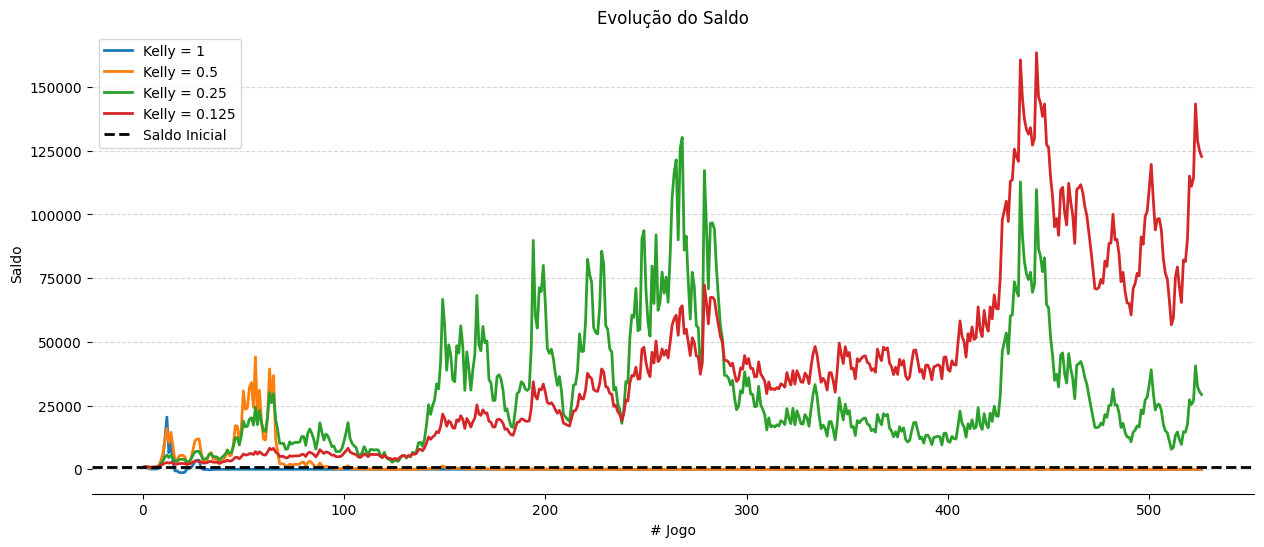

,total_apostado,%_jogos_apostados,%_apostas_ganhas,fracao_kelly,saldo_final,%_roi
0,30675.81,49.24,93.82,1.000,0.00,-100.00
1,154317.10,99.81,46.29,0.500,0.00,-100.00
2,1221300.18,99.81,46.29,0.250,29334.07,2833.41
3,746201.62,99.81,46.29,0.125,122749.08,12174.91


In [153]:
df_estrategia1 = betting_simulation(B0=1000,Pmin=0, Lt=0, Ut=1)
df_estrategia1

Lucro total (k = 1): 11344.64674864961
Lucro total (k = 0.5): 80365.4373239962
Lucro total (k = 0.25): 1025123.9369307718
Lucro total (k = 0.125): 565297.3870437826


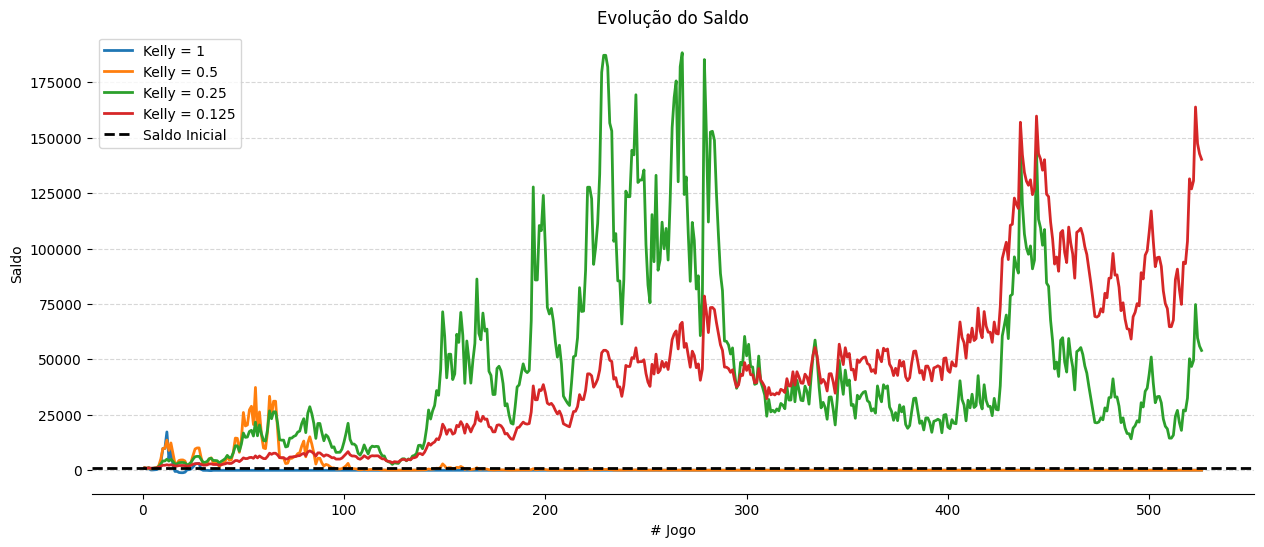

,total_apostado,%_jogos_apostados,%_apostas_ganhas,fracao_kelly,saldo_final,%_roi
0,27332.38,46.58,104.90,1.000,-0.00,-100.00
1,171153.39,99.81,48.95,0.500,0.00,-100.00
2,1882389.25,99.81,48.95,0.250,54022.52,5302.25
3,805194.79,99.81,48.95,0.125,140283.41,13928.34


In [154]:
df_estrategia2 = betting_simulation(B0=1000,Pmin=0.3, Lt=0, Ut=0.5)
df_estrategia2

Lucro total (k = 1): -623.1797142681515
Lucro total (k = 0.5): 16903.461747637662
Lucro total (k = 0.25): 108853.07245967221
Lucro total (k = 0.125): 95891.91930228993


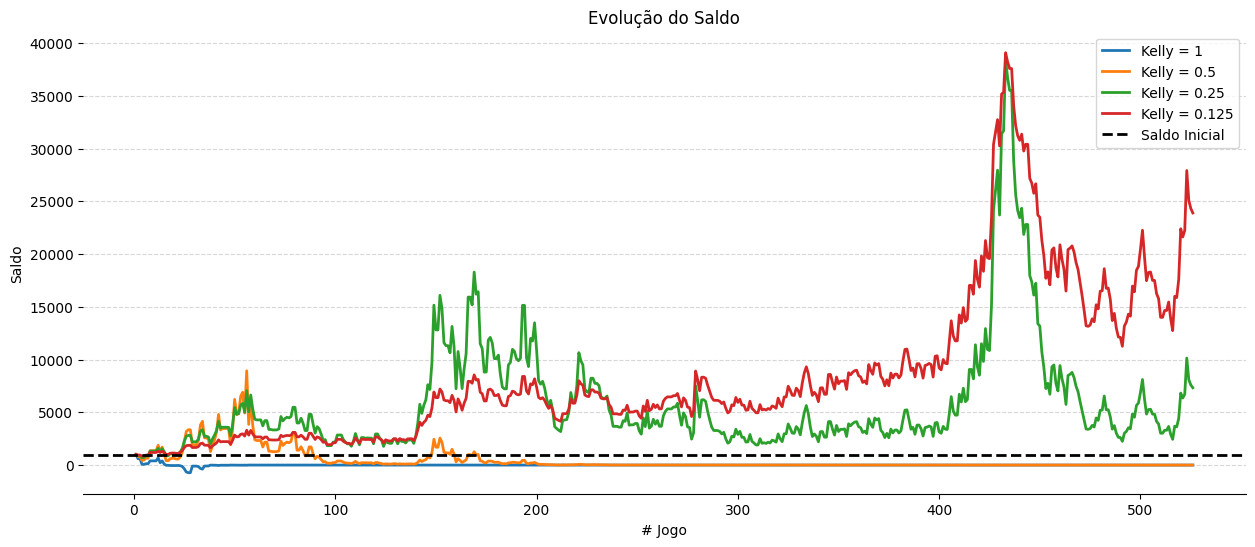

,total_apostado,%_jogos_apostados,%_apostas_ganhas,fracao_kelly,saldo_final,%_roi
0,110.20,42.78,108.00,1.000,-0.00,-100.00
1,39129.13,99.81,46.29,0.500,0.00,-100.00
2,204604.58,99.81,46.29,0.250,7329.52,632.95
3,145150.81,99.81,46.29,0.125,23896.66,2289.67


In [161]:
df_estrategia3 = betting_simulation(B0=1000,Pmin=0, Lt=0, Ut=0.4)
df_estrategia3